# Part 2: Predicting Energy Output at Turbine Locations

In this notebook, we will predict the energy output of each turbine using our predicted wind speed. We will then compare with actual energy output if actual wind speed is used instead.

(Note: In this case, actual energy output is still an interpolated value from best-fit energy curves. We do not actually have energy output values for each turbine at specific time points)

First, we once again load up previously created datasets.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import numpy as np

longitude_start = -124.0
longitude_end =  -120.0

latitude_start = 36.0
latitude_end = 40.0

spacing = 0.25

longitude_range = np.arange(longitude_start, longitude_end + spacing, spacing)
latitude_range = np.arange(latitude_start, latitude_end + spacing, spacing)

longitude_range, latitude_range

(array([-124.  , -123.75, -123.5 , -123.25, -123.  , -122.75, -122.5 ,
        -122.25, -122.  , -121.75, -121.5 , -121.25, -121.  , -120.75,
        -120.5 , -120.25, -120.  ]),
 array([36.  , 36.25, 36.5 , 36.75, 37.  , 37.25, 37.5 , 37.75, 38.  ,
        38.25, 38.5 , 38.75, 39.  , 39.25, 39.5 , 39.75, 40.  ]))

In [26]:
turbine_energy_df = pd.read_csv('/content/drive/MyDrive/CS 663 - Project/Imputed_Turbine_Energy.csv')
turbine_energy_df

,Unnamed: 0,Manufacturer,Model,Rated Power (kW),Cut-in Wind Speed (m/s),Rated Wind Speed (m/s),Cut-out Wind Speed (m/s),Rotor Diameter (m),Swept Area (m^2),Power Density 1 (W/m^2),...,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5
0,0,GE Wind,GE1.7-100,1700.0,3.0,10.00,23.0,100.0,7854.00,216.5,...,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
1,1,NEG Micon,NM19,108.0,4.0,14.00,30.0,18.9,280.55,385.7,...,107.358669,107.544423,107.676538,107.770422,107.837098,107.884430,107.918020,107.941852,107.958759,107.970751
2,2,Endurance,E-3120,50.0,3.5,10.00,25.0,19.2,290.00,172.4,...,104.848473,104.896671,104.929548,104.951969,104.967257,104.977680,104.984785,104.989629,104.992931,104.995182
3,3,NEG Micon,NM48,750.0,4.0,16.00,25.0,48.2,1824.00,411.2,...,749.700000,735.100000,715.500000,706.300000,697.200000,692.900000,683.300000,652.800000,652.800000,652.800000
4,4,PowerWind,PW56-900,900.0,3.0,12.50,25.0,56.0,2463.00,365.4,...,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
5,5,Aeronautica,47-750,750.0,3.5,14.50,25.0,47.0,1735.00,432.3,...,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
6,6,GE Wind,GE1.5-77,1500.0,3.5,12.00,25.0,77.0,4657.00,322.1,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
7,7,GE Wind,GE2.7-116,2700.0,3.0,10.68,24.0,116.0,10660.00,253.3,...,2699.741866,2699.836936,2699.896993,2699.934931,2699.958897,2699.974036,2699.983599,2699.989640,2699.993456,2699.995866
8,8,GE Wind,GE2.82-127,2800.0,3.0,8.00,25.0,127.0,12667.00,221.0,...,2799.732305,2799.830896,2799.893178,2799.932521,2799.957375,2799.973074,2799.982991,2799.989256,2799.993213,2799.995713
9,9,GE Wind,GE1.85-82.5,1850.0,3.0,13.00,25.0,82.5,5346.00,346.1,...,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000


In [27]:
sf_area_turbines_df = pd.read_csv('/content/drive/MyDrive/CS 663 - Project/SF_Area_Turbines.csv')
sf_area_turbines_df

,Unnamed: 0,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,...,t_ttlh,retrofit,retrofit_y,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,geometry
0,1402,3048446.0,06-037710,2013-WTW-7671-OE,-9999.0,59331.0,CA,Solano County,6095,Anheuser-Busch Fairfield,...,121.3,0.0,-9999.0,3.0,3.0,2017-08-19,Digital Globe,-122.092079,38.233505,POINT (-122.092079 38.233505)
1,1403,3040085.0,06-022141,2011-WTW-11924-OE,13315.0,59331.0,CA,Solano County,6095,Anheuser-Busch Fairfield,...,103.6,0.0,-9999.0,3.0,3.0,2020-08-27,Digital Globe,-122.089287,38.232296,POINT (-122.089287 38.232296)
2,7998,3036014.0,06-020764,2010-WTW-12669-OE,12004.0,56446.0,CA,Contra Costa County,6013,Buena Vista,...,85.6,0.0,-9999.0,3.0,3.0,2012-01-01,NAIP,-121.644188,37.796196,POINT (-121.644188 37.796196)
3,7999,3020634.0,06-020723,2006-AWP-4981-OE,12027.0,56446.0,CA,Contra Costa County,6013,Buena Vista,...,85.6,0.0,-9999.0,3.0,3.0,2020-03-03,Digital Globe,-121.666084,37.801395,POINT (-121.666084 37.801395)
4,8000,3020645.0,06-020776,2006-AWP-5001-OE,12032.0,56446.0,CA,Contra Costa County,6013,Buena Vista,...,85.6,0.0,-9999.0,3.0,3.0,2012-01-01,NAIP,-121.653885,37.802994,POINT (-121.653885 37.802994)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,66184,3039830.0,06-022144,2011-WTW-10310-OE,11999.0,57700.0,CA,Contra Costa County,6013,Vasco (repower),...,130.5,0.0,-9999.0,3.0,3.0,2012-01-01,NAIP,-121.709885,37.794193,POINT (-121.709885 37.794193)
945,66185,3039895.0,06-022125,2011-WTW-10978-OE,11992.0,57700.0,CA,Contra Costa County,6013,Vasco (repower),...,130.5,0.0,-9999.0,3.0,3.0,2012-01-01,NAIP,-121.701584,37.789993,POINT (-121.701584 37.789993)
946,66186,3039831.0,06-022145,2011-WTW-10311-OE,11991.0,57700.0,CA,Contra Costa County,6013,Vasco (repower),...,130.5,0.0,-9999.0,3.0,3.0,2020-03-03,Digital Globe,-121.710487,37.788895,POINT (-121.710487 37.788895)
947,66187,3039880.0,06-022148,2011-WTW-10641-OE,12039.0,57700.0,CA,Contra Costa County,6013,Vasco (repower),...,130.5,0.0,-9999.0,3.0,3.0,2012-01-01,NAIP,-121.726784,37.804794,POINT (-121.726784 37.804794)


In [28]:
sf_area_turbines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  949 non-null    int64  
 1   case_id     949 non-null    float64
 2   faa_ors     949 non-null    object 
 3   faa_asn     949 non-null    object 
 4   usgs_pr_id  949 non-null    float64
 5   eia_id      949 non-null    float64
 6   t_state     949 non-null    object 
 7   t_county    949 non-null    object 
 8   t_fips      949 non-null    int64  
 9   p_name      949 non-null    object 
 10  p_year      949 non-null    float64
 11  p_tnum      949 non-null    float64
 12  p_cap       949 non-null    float64
 13  t_manu      949 non-null    object 
 14  t_model     949 non-null    object 
 15  t_cap       949 non-null    float64
 16  t_hh        949 non-null    float64
 17  t_rd        949 non-null    float64
 18  t_rsa       949 non-null    float64
 19  t_ttlh      949 non-null    f

In [29]:
sf_area_turbines_df = sf_area_turbines_df.loc[:,['t_manu', 't_model', 't_cap', 't_hh', 'xlong', 'ylat', 'geometry']]
sf_area_turbines_df

,t_manu,t_model,t_cap,t_hh,xlong,ylat,geometry
0,GE Wind,GE1.85-82.5,1850.0,80.0,-122.092079,38.233505,POINT (-122.092079 38.233505)
1,GE Wind,GE1.5-77,1500.0,65.0,-122.089287,38.232296,POINT (-122.089287 38.232296)
2,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.644188,37.796196,POINT (-121.644188 37.796196)
3,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.666084,37.801395,POINT (-121.666084 37.801395)
4,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.653885,37.802994,POINT (-121.653885 37.802994)
...,...,...,...,...,...,...,...
944,Siemens,SWT-2.3-101,2300.0,80.0,-121.709885,37.794193,POINT (-121.709885 37.794193)
945,Siemens,SWT-2.3-101,2300.0,80.0,-121.701584,37.789993,POINT (-121.701584 37.789993)
946,Siemens,SWT-2.3-101,2300.0,80.0,-121.710487,37.788895,POINT (-121.710487 37.788895)
947,Siemens,SWT-2.3-101,2300.0,80.0,-121.726784,37.804794,POINT (-121.726784 37.804794)


In [35]:
own_predictions_df = pd.read_csv('/content/drive/My Drive/CS 663 - Project/Bay_Area_Test_Predictions.csv')
own_predictions_df

own_target_df = pd.read_csv('/content/drive/My Drive/CS 663 - Project/Bay_Area_Test_Targets.csv')
own_target_df

,Unnamed: 0,Epoch,Latitude,Longitude,Value,Datetime
0,0,0,0,0,8.375953,2023-11-07 06:00:00
1,1,0,0,1,8.099626,2023-11-07 06:00:00
2,2,0,0,2,7.828717,2023-11-07 06:00:00
3,3,0,0,3,7.539246,2023-11-07 06:00:00
4,4,0,0,4,7.122887,2023-11-07 06:00:00
...,...,...,...,...,...,...
379741,379741,33,16,12,0.792793,2023-12-31 23:00:00
379742,379742,33,16,13,0.875743,2023-12-31 23:00:00
379743,379743,33,16,14,1.116978,2023-12-31 23:00:00
379744,379744,33,16,15,1.474789,2023-12-31 23:00:00


In [36]:
own_specific_predictions_df = own_predictions_df[own_predictions_df['Datetime'] == '2023-12-29 13:00:00']
own_specific_predictions_df

own_specific_target_df = own_target_df[own_target_df['Datetime'] == '2023-12-29 13:00:00']
own_specific_target_df

,Unnamed: 0,Epoch,Latitude,Longitude,Value,Datetime
362695,362695,39,0,0,14.267251,2023-12-29 13:00:00
362696,362696,39,0,1,13.287450,2023-12-29 13:00:00
362697,362697,39,0,2,12.449271,2023-12-29 13:00:00
362698,362698,39,0,3,11.785383,2023-12-29 13:00:00
362699,362699,39,0,4,10.995699,2023-12-29 13:00:00
...,...,...,...,...,...,...
362979,362979,39,16,12,3.344776,2023-12-29 13:00:00
362980,362980,39,16,13,3.124060,2023-12-29 13:00:00
362981,362981,39,16,14,3.021753,2023-12-29 13:00:00
362982,362982,39,16,15,3.428508,2023-12-29 13:00:00


In [37]:
predictions_pivot_table = own_specific_predictions_df.pivot(index='Latitude', columns='Longitude', values='Value')
target_pivot_table = own_specific_target_df.pivot(index='Latitude', columns='Longitude', values='Value')

target_pivot_table

Longitude,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Latitude,,,,,,,,,,,,,,,,,
0,14.267251,13.287450,12.449271,11.785383,10.995699,10.377944,9.509956,8.569242,8.243561,7.572111,5.886447,4.676004,5.003383,4.308804,3.799286,3.456251,2.438721
1,14.620593,13.707492,12.840879,11.954629,11.142078,10.429994,9.747807,9.056195,9.078957,6.854908,5.212753,5.002424,5.693051,4.618354,3.558917,2.951599,2.341641
2,14.950538,14.028420,13.078997,12.162977,11.292173,10.283063,9.720452,9.270867,8.984671,6.245761,5.433799,5.280234,5.930416,4.526194,3.461184,3.254205,3.437212
3,15.264469,14.337370,13.352741,12.280518,11.299169,10.239578,9.539101,9.145005,7.614945,4.674869,4.148488,4.695528,5.116097,3.690761,3.983750,4.590946,4.124396
4,15.555143,14.578869,13.584142,12.499651,11.243269,10.313084,9.407820,7.921147,5.720503,3.135273,2.657498,3.123654,3.655209,3.785581,4.675342,4.931756,3.736388
5,15.745661,14.839247,13.794622,12.625055,11.375385,10.433396,8.575777,6.587261,5.169689,4.449571,3.727547,3.420772,3.702100,4.575326,5.214881,5.149592,4.089478
6,16.133879,15.171798,13.874641,12.496379,11.381547,10.218233,7.897538,5.679039,4.789884,5.419429,5.265518,5.064451,5.237724,5.359065,5.310581,4.997544,4.569933
7,16.409807,15.286103,13.932054,12.575319,11.432764,9.467450,7.077075,4.798379,3.785128,4.698857,5.589412,6.035130,6.520847,5.650612,5.206200,4.410270,4.096453
8,16.831861,15.526781,14.160357,12.478684,10.741620,8.254982,5.689941,3.564425,2.639954,4.244575,5.493734,6.735576,7.238848,6.331020,5.354360,4.602369,4.310188


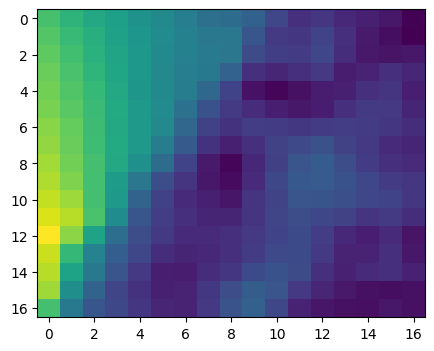

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.imshow(target_pivot_table, cmap='viridis', aspect='auto')

In [39]:
target_pivot_table.index = latitude_range
target_pivot_table.columns = longitude_range

predictions_pivot_table.index = latitude_range
predictions_pivot_table.columns = longitude_range

target_pivot_table
predictions_pivot_table

,-124.00,-123.75,-123.50,-123.25,-123.00,-122.75,-122.50,-122.25,-122.00,-121.75,-121.50,-121.25,-121.00,-120.75,-120.50,-120.25,-120.00
36.00,14.194774,13.603587,13.018031,12.400240,11.743598,11.209903,10.436892,9.788149,9.359803,7.941016,5.556998,3.489881,3.421115,2.971150,2.389932,1.614909,1.519384
36.25,14.392451,13.812952,13.196347,12.494094,11.933879,11.388897,10.684288,10.203965,9.524503,6.795260,4.497103,3.947386,4.200362,3.272077,2.196453,1.777590,2.049403
36.50,14.526238,14.001455,13.316690,12.632723,12.033982,11.405093,10.791266,9.749593,8.776114,5.786728,4.712052,4.233305,4.703676,3.575570,2.790784,2.767118,3.044132
36.75,14.767900,14.189135,13.487510,12.814194,12.114011,11.425459,10.206814,9.179580,7.286216,4.835935,4.060854,4.159976,4.488491,3.662931,3.740537,4.058828,3.927748
37.00,14.940904,14.263401,13.579992,12.985309,12.324273,11.401190,10.145046,8.231939,5.914679,4.070627,3.606982,3.769420,4.104527,4.144549,4.528414,4.755588,4.328300
37.25,15.158373,14.642792,13.975939,13.267893,12.682644,11.485153,9.261760,7.006273,5.357419,4.702066,4.310758,4.124685,4.326367,4.687578,5.031368,5.132453,4.668618
37.50,15.529296,14.942257,14.138889,13.335920,12.700612,11.191657,8.791480,6.664199,5.904560,5.716522,5.357624,5.154262,5.101395,5.234238,5.270910,5.248604,4.756943
37.75,15.811186,15.182059,14.259272,13.527661,12.511386,10.221231,7.965218,6.050227,5.290944,5.195828,5.406154,5.618777,5.970368,5.785875,5.586038,4.954604,4.392618
38.00,16.166014,15.359838,14.441778,12.954823,11.283401,8.714077,6.457991,4.993507,4.758673,5.203376,5.590577,6.242474,6.678994,6.469919,5.943333,5.361855,4.565232
38.25,16.409477,15.589166,13.964108,11.818830,9.244223,6.568622,5.304662,4.520225,4.563767,5.192072,5.946053,6.525411,6.751293,6.800687,6.700216,5.847526,5.043290


In [40]:
target_pivot_table = target_pivot_table.reindex(reversed(latitude_range))
predictions_pivot_table = predictions_pivot_table.reindex(reversed(latitude_range))
target_pivot_table
predictions_pivot_table

,-124.00,-123.75,-123.50,-123.25,-123.00,-122.75,-122.50,-122.25,-122.00,-121.75,-121.50,-121.25,-121.00,-120.75,-120.50,-120.25,-120.00
40.00,12.739702,9.145062,7.252851,6.207809,5.180894,4.166771,4.419296,4.786311,5.535043,5.764155,5.207281,4.549472,4.042778,3.782086,3.547863,3.483013,3.164618
39.75,15.130232,10.313179,7.894168,6.194589,4.815708,3.463431,3.482031,4.086152,4.675156,5.298430,5.371971,5.152115,5.122695,4.706454,4.129576,3.570749,3.185149
39.50,15.585136,11.367812,8.901086,6.967068,5.331261,3.599597,3.357903,3.636488,4.083185,4.674160,5.264870,5.516617,5.593665,5.406771,5.360927,5.008383,3.862503
39.25,15.868258,11.986173,9.218614,7.448677,6.090434,4.461182,3.823921,3.621234,4.034804,4.603170,5.242120,5.833055,5.948315,5.662277,5.458471,5.458017,3.964443
39.00,17.236877,14.374014,10.870441,8.131155,6.335888,5.126524,4.145767,3.718344,4.091102,4.807276,5.370085,6.062966,6.096888,5.956980,5.718561,5.427694,4.081081
38.75,16.590975,15.922191,13.074993,10.137528,6.879961,5.393273,4.323169,3.870612,4.114945,4.949517,5.776987,6.381691,6.482445,6.733296,6.365454,5.953877,5.134522
38.50,16.609232,15.953116,13.530646,10.967621,7.676521,5.751485,4.628950,4.121264,4.251336,5.157359,5.987603,6.591397,6.874120,7.139912,6.881367,6.029668,5.197604
38.25,16.409477,15.589166,13.964108,11.818830,9.244223,6.568622,5.304662,4.520225,4.563767,5.192072,5.946053,6.525411,6.751293,6.800687,6.700216,5.847526,5.043290
38.00,16.166014,15.359838,14.441778,12.954823,11.283401,8.714077,6.457991,4.993507,4.758673,5.203376,5.590577,6.242474,6.678994,6.469919,5.943333,5.361855,4.565232
37.75,15.811186,15.182059,14.259272,13.527661,12.511386,10.221231,7.965218,6.050227,5.290944,5.195828,5.406154,5.618777,5.970368,5.785875,5.586038,4.954604,4.392618


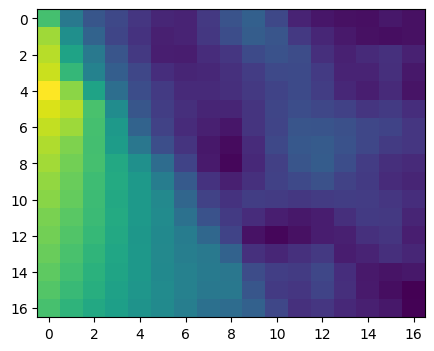

In [42]:
fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.imshow(target_pivot_table, cmap='viridis', aspect='auto')

We are able to ingest and transform data as necessary in the above cells. In the below cells, we will

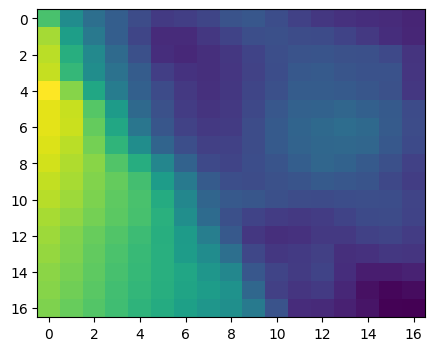

In [43]:
fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.imshow(predictions_pivot_table, cmap='viridis', aspect='auto')

In [44]:
sf_area_turbines_with_ws = sf_area_turbines_df.copy()
sf_area_turbines_with_ws['predicted_ws'] = 0.
sf_area_turbines_with_ws['actual_ws'] = 0.
sf_area_turbines_with_ws

,t_manu,t_model,t_cap,t_hh,xlong,ylat,geometry,predicted_ws,actual_ws
0,GE Wind,GE1.85-82.5,1850.0,80.0,-122.092079,38.233505,POINT (-122.092079 38.233505),0.0,0.0
1,GE Wind,GE1.5-77,1500.0,65.0,-122.089287,38.232296,POINT (-122.089287 38.232296),0.0,0.0
2,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.644188,37.796196,POINT (-121.644188 37.796196),0.0,0.0
3,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.666084,37.801395,POINT (-121.666084 37.801395),0.0,0.0
4,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.653885,37.802994,POINT (-121.653885 37.802994),0.0,0.0
...,...,...,...,...,...,...,...,...,...
944,Siemens,SWT-2.3-101,2300.0,80.0,-121.709885,37.794193,POINT (-121.709885 37.794193),0.0,0.0
945,Siemens,SWT-2.3-101,2300.0,80.0,-121.701584,37.789993,POINT (-121.701584 37.789993),0.0,0.0
946,Siemens,SWT-2.3-101,2300.0,80.0,-121.710487,37.788895,POINT (-121.710487 37.788895),0.0,0.0
947,Siemens,SWT-2.3-101,2300.0,80.0,-121.726784,37.804794,POINT (-121.726784 37.804794),0.0,0.0


In [47]:
import math

def impute_wind_speed_at_location(df, target_longitude, target_latitude, point_1, point_2, point_3, point_4):
  p_1_long = point_1[0]
  p_1_lat = point_1[1]
  p_2_long = point_2[0]
  p_2_lat = point_2[1]
  p_3_long = point_3[0]
  p_3_lat = point_3[1]
  p_4_long = point_4[0]
  p_4_lat = point_4[1]

  # calculate distance between points and target_long, lat


  p_1_dist = math.sqrt((target_longitude - p_1_long)**2 + (target_latitude - p_1_lat)**2)
  p_2_dist = math.sqrt((target_longitude - p_2_long)**2 + (target_latitude - p_2_lat)**2)
  p_3_dist = math.sqrt((target_longitude - p_3_long)**2 + (target_latitude - p_3_lat)**2)
  p_4_dist = math.sqrt((target_longitude - p_4_long)**2 + (target_latitude - p_4_lat)**2)

  p_1_weight = p_1_dist * 1 / sum([p_1_dist, p_2_dist, p_3_dist, p_4_dist])
  p_2_weight = p_2_dist * 1 / sum([p_1_dist, p_2_dist, p_3_dist, p_4_dist])
  p_3_weight = p_3_dist * 1 / sum([p_1_dist, p_2_dist, p_3_dist, p_4_dist])
  p_4_weight = p_4_dist * 1 / sum([p_1_dist, p_2_dist, p_3_dist, p_4_dist])

  # print('points:', point_1, point_2, point_3, point_4)
  # print('weights:', p_1_weight, p_2_weight, p_3_weight, p_4_weight)
  # print('ws:', df[p_1_long][p_1_lat], df[p_2_long][p_2_lat], df[p_3_long][p_3_lat], df[p_4_long][p_4_lat])

  return (df[p_1_long][p_1_lat] * p_1_weight) + (df[p_2_long][p_2_lat] * p_2_weight) + (df[p_3_long][p_3_lat] * p_3_weight) + (df[p_4_long][p_4_lat] * p_4_weight)

def get_wind_speed_at_location(dataframe, longitude, latitude, longitude_range, latitude_range): # dataframe contains long, lat, ws
  point_1, point_2, point_3, point_4 = find_bounded_4_corners(longitude, latitude, longitude_range, latitude_range)
  if point_1 is None:
    return None
  return impute_wind_speed_at_location(dataframe, longitude, latitude, point_1, point_2, point_3, point_4)

def find_bounded_4_corners(longitude, latitude, longitude_range, latitude_range):
  #
  #   1-------2
  #   |       |
  #   |       |
  #   |       |
  #   3-------4
  #
  # print('longitude =', longitude, 'latitude =', latitude, 'longitude_range =', longitude_range, 'latitude_range=', latitude_range)
  if (longitude < longitude_range[0] or longitude > longitude_range[-1]) or (latitude < latitude_range[0] or latitude > latitude_range[-1]) :
    return None

  left_bound_long = longitude_range[0]
  right_bound_long = longitude_range[-1]
  top_bound_lat = latitude_range[-1]
  bottom_bound_lat = latitude_range[0]

  for l in longitude_range:
    if longitude > l:
      left_bound_long = l
  for l in reversed(longitude_range):
    if longitude < l:
      right_bound_long = l

  for l in latitude_range:
    if latitude > l:
      bottom_bound_lat = l
  for l in reversed(latitude_range):
    if latitude < l:
      top_bound_lat = l

  point_1_long = left_bound_long
  point_1_lat = top_bound_lat
  point_2_long = right_bound_long
  point_2_lat = top_bound_lat
  point_3_long = left_bound_long
  point_3_lat = bottom_bound_lat
  point_4_long = right_bound_long
  point_4_lat = bottom_bound_lat

  return (point_1_long, point_1_lat), (point_2_long, point_2_lat), (point_3_long, point_3_lat), (point_4_long, point_4_lat)


p1, p2, p3, p4 = find_bounded_4_corners( -122.4533, 38.2, longitude_range, latitude_range)
ws = impute_wind_speed_at_location(predictions_pivot_table, -122.4533, 38.2, p1, p2, p3, p4)
print('points:', p1, p2, p3, p4, "wind speed is: ", ws)
# predicted_wind_speed_df

points: (-122.5, 38.25) (-122.25, 38.25) (-122.5, 38.0) (-122.25, 38.0) wind speed is:  5.283714437649623


In [46]:
predictions_pivot_table

,-124.00,-123.75,-123.50,-123.25,-123.00,-122.75,-122.50,-122.25,-122.00,-121.75,-121.50,-121.25,-121.00,-120.75,-120.50,-120.25,-120.00
40.00,12.739702,9.145062,7.252851,6.207809,5.180894,4.166771,4.419296,4.786311,5.535043,5.764155,5.207281,4.549472,4.042778,3.782086,3.547863,3.483013,3.164618
39.75,15.130232,10.313179,7.894168,6.194589,4.815708,3.463431,3.482031,4.086152,4.675156,5.298430,5.371971,5.152115,5.122695,4.706454,4.129576,3.570749,3.185149
39.50,15.585136,11.367812,8.901086,6.967068,5.331261,3.599597,3.357903,3.636488,4.083185,4.674160,5.264870,5.516617,5.593665,5.406771,5.360927,5.008383,3.862503
39.25,15.868258,11.986173,9.218614,7.448677,6.090434,4.461182,3.823921,3.621234,4.034804,4.603170,5.242120,5.833055,5.948315,5.662277,5.458471,5.458017,3.964443
39.00,17.236877,14.374014,10.870441,8.131155,6.335888,5.126524,4.145767,3.718344,4.091102,4.807276,5.370085,6.062966,6.096888,5.956980,5.718561,5.427694,4.081081
38.75,16.590975,15.922191,13.074993,10.137528,6.879961,5.393273,4.323169,3.870612,4.114945,4.949517,5.776987,6.381691,6.482445,6.733296,6.365454,5.953877,5.134522
38.50,16.609232,15.953116,13.530646,10.967621,7.676521,5.751485,4.628950,4.121264,4.251336,5.157359,5.987603,6.591397,6.874120,7.139912,6.881367,6.029668,5.197604
38.25,16.409477,15.589166,13.964108,11.818830,9.244223,6.568622,5.304662,4.520225,4.563767,5.192072,5.946053,6.525411,6.751293,6.800687,6.700216,5.847526,5.043290
38.00,16.166014,15.359838,14.441778,12.954823,11.283401,8.714077,6.457991,4.993507,4.758673,5.203376,5.590577,6.242474,6.678994,6.469919,5.943333,5.361855,4.565232
37.75,15.811186,15.182059,14.259272,13.527661,12.511386,10.221231,7.965218,6.050227,5.290944,5.195828,5.406154,5.618777,5.970368,5.785875,5.586038,4.954604,4.392618


In [48]:
for index, row in sf_area_turbines_with_ws.iterrows():
  # print('-------------')
  # print('longitude =', row['xlong'], 'latitude =', row['ylat'])

  sf_area_turbines_with_ws.iloc[index, 7] = get_wind_speed_at_location(predictions_pivot_table, row['xlong'], row['ylat'], longitude_range, latitude_range)
  sf_area_turbines_with_ws.iloc[index, 8] = get_wind_speed_at_location(target_pivot_table, row['xlong'], row['ylat'], longitude_range, latitude_range)

sf_area_turbines_with_ws

,t_manu,t_model,t_cap,t_hh,xlong,ylat,geometry,predicted_ws,actual_ws
0,GE Wind,GE1.85-82.5,1850.0,80.0,-122.092079,38.233505,POINT (-122.092079 38.233505),4.771542,3.157853
1,GE Wind,GE1.5-77,1500.0,65.0,-122.089287,38.232296,POINT (-122.089287 38.232296),4.771477,3.161720
2,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.644188,37.796196,POINT (-121.644188 37.796196),5.372908,5.005712
3,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.666084,37.801395,POINT (-121.666084 37.801395),5.383831,5.050606
4,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.653885,37.802994,POINT (-121.653885 37.802994),5.377259,5.027925
...,...,...,...,...,...,...,...,...,...
944,Siemens,SWT-2.3-101,2300.0,80.0,-121.709885,37.794193,POINT (-121.709885 37.794193),5.405048,5.122376
945,Siemens,SWT-2.3-101,2300.0,80.0,-121.701584,37.789993,POINT (-121.701584 37.789993),5.401993,5.107288
946,Siemens,SWT-2.3-101,2300.0,80.0,-121.710487,37.788895,POINT (-121.710487 37.788895),5.405855,5.120672
947,Siemens,SWT-2.3-101,2300.0,80.0,-121.726784,37.804794,POINT (-121.726784 37.804794),5.409711,5.150680


In [49]:
sf_area_turbines_with_ws['predicted_ws - actual_ws'] = sf_area_turbines_with_ws['predicted_ws'] - sf_area_turbines_with_ws['actual_ws']
sf_area_turbines_with_ws

,t_manu,t_model,t_cap,t_hh,xlong,ylat,geometry,predicted_ws,actual_ws,predicted_ws - actual_ws
0,GE Wind,GE1.85-82.5,1850.0,80.0,-122.092079,38.233505,POINT (-122.092079 38.233505),4.771542,3.157853,1.613688
1,GE Wind,GE1.5-77,1500.0,65.0,-122.089287,38.232296,POINT (-122.089287 38.232296),4.771477,3.161720,1.609757
2,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.644188,37.796196,POINT (-121.644188 37.796196),5.372908,5.005712,0.367195
3,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.666084,37.801395,POINT (-121.666084 37.801395),5.383831,5.050606,0.333225
4,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.653885,37.802994,POINT (-121.653885 37.802994),5.377259,5.027925,0.349334
...,...,...,...,...,...,...,...,...,...,...
944,Siemens,SWT-2.3-101,2300.0,80.0,-121.709885,37.794193,POINT (-121.709885 37.794193),5.405048,5.122376,0.282672
945,Siemens,SWT-2.3-101,2300.0,80.0,-121.701584,37.789993,POINT (-121.701584 37.789993),5.401993,5.107288,0.294705
946,Siemens,SWT-2.3-101,2300.0,80.0,-121.710487,37.788895,POINT (-121.710487 37.788895),5.405855,5.120672,0.285183
947,Siemens,SWT-2.3-101,2300.0,80.0,-121.726784,37.804794,POINT (-121.726784 37.804794),5.409711,5.150680,0.259032


In [50]:
sf_area_turbines_with_ws['predicted_energy'] = 0.
sf_area_turbines_with_ws['actual_energy'] = 0.
sf_area_turbines_with_ws

,t_manu,t_model,t_cap,t_hh,xlong,ylat,geometry,predicted_ws,actual_ws,predicted_ws - actual_ws,predicted_energy,actual_energy
0,GE Wind,GE1.85-82.5,1850.0,80.0,-122.092079,38.233505,POINT (-122.092079 38.233505),4.771542,3.157853,1.613688,0.0,0.0
1,GE Wind,GE1.5-77,1500.0,65.0,-122.089287,38.232296,POINT (-122.089287 38.232296),4.771477,3.161720,1.609757,0.0,0.0
2,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.644188,37.796196,POINT (-121.644188 37.796196),5.372908,5.005712,0.367195,0.0,0.0
3,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.666084,37.801395,POINT (-121.666084 37.801395),5.383831,5.050606,0.333225,0.0,0.0
4,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.653885,37.802994,POINT (-121.653885 37.802994),5.377259,5.027925,0.349334,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
944,Siemens,SWT-2.3-101,2300.0,80.0,-121.709885,37.794193,POINT (-121.709885 37.794193),5.405048,5.122376,0.282672,0.0,0.0
945,Siemens,SWT-2.3-101,2300.0,80.0,-121.701584,37.789993,POINT (-121.701584 37.789993),5.401993,5.107288,0.294705,0.0,0.0
946,Siemens,SWT-2.3-101,2300.0,80.0,-121.710487,37.788895,POINT (-121.710487 37.788895),5.405855,5.120672,0.285183,0.0,0.0
947,Siemens,SWT-2.3-101,2300.0,80.0,-121.726784,37.804794,POINT (-121.726784 37.804794),5.409711,5.150680,0.259032,0.0,0.0


In [68]:
for index, row in sf_area_turbines_with_ws.iterrows():
  model = row['t_model']
  forecast_ws = row['predicted_ws']
  actual_ws = row['actual_ws']
  wind_speed_range = np.arange(0, 22, 0.5)
  # print(wind_speed_range)
  # find row in turbine_energy_df
  energy_info = turbine_energy_df.loc[turbine_energy_df['Model'] == model,:]
  ## impute wind energy
  # print('-------------------')
  # print('forecast_ws:', forecast_ws, 'actual_ws:', actual_ws)
  # print('int forecast_ws:', int(forecast_ws), 'int actual_ws:', int(actual_ws))
  forecast_low_threshold = math.floor(forecast_ws)
  if forecast_ws - int(forecast_ws) > 0.5:
    forecast_low_threshold += 0.5
  forecast_high_threshold = math.ceil(forecast_ws)
  if forecast_ws - int(forecast_ws) <= 0.5:
    forecast_high_threshold -= 0.5
  # print('forecast_low_threshold:', forecast_low_threshold, 'forecast_high_threshold:', forecast_high_threshold)
  actual_low_threshold = math.floor(actual_ws)
  actual_high_threshold = math.ceil(actual_ws)
  if actual_ws - int(actual_ws) > 0.5:
    actual_low_threshold += 0.5
  forecast_high_threshold = math.ceil(forecast_ws)
  if actual_ws - int(actual_ws) <= 0.5:
    actual_high_threshold -= 0.5
  # print('actual_low_threshold:', actual_low_threshold, 'actual_high_threshold:', actual_high_threshold)

  ## get the value from energy_info
  energy_low_bound = energy_info.iloc[0, energy_info.columns.tolist().index(str(forecast_low_threshold))]
  energy_high_bound = energy_info.iloc[0, energy_info.columns.tolist().index(str(forecast_high_threshold))]
  energy_slope = (energy_high_bound - energy_low_bound) / 0.5
  forecast_energy = energy_slope * (forecast_ws - forecast_low_threshold) + energy_low_bound

  energy_low_bound = energy_info.iloc[0, energy_info.columns.tolist().index(str(actual_low_threshold))]
  energy_high_bound = energy_info.iloc[0, energy_info.columns.tolist().index(str(actual_high_threshold))]
  energy_slope = (energy_high_bound - energy_low_bound) / 0.5
  actual_energy = energy_slope * (actual_ws - actual_low_threshold) + energy_low_bound
  # print(forecast_energy, actual_energy)

  sf_area_turbines_with_ws.iloc[index, 10] = forecast_energy
  sf_area_turbines_with_ws.iloc[index, 11] = actual_energy
  # sf_area_turbines_with_ws.iloc[index, 10] = (energy_info.iloc[0, energy_info.columns.tolist().index(str(actual_low_threshold))] + energy_info.iloc[0, energy_info.columns.tolist().index(str(actual_high_threshold))]) / 2
  # print(energy_info.info())

sf_area_turbines_with_ws

,t_manu,t_model,t_cap,t_hh,xlong,ylat,geometry,predicted_ws,actual_ws,predicted_ws - actual_ws,predicted_energy,actual_energy,predicted_energy - actual_energy
0,GE Wind,GE1.85-82.5,1850.0,80.0,-122.092079,38.233505,POINT (-122.092079 38.233505),4.771542,3.157853,1.613688,168.558913,16.102607,152.456306
1,GE Wind,GE1.5-77,1500.0,65.0,-122.089287,38.232296,POINT (-122.089287 38.232296),4.771477,3.161720,1.609757,109.061794,6.468795,102.592998
2,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.644188,37.796196,POINT (-121.644188 37.796196),5.372908,5.005712,0.367195,132.006227,44.639774,238.182335
3,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.666084,37.801395,POINT (-121.666084 37.801395),5.383831,5.050606,0.333225,134.584012,49.667876,236.693225
4,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.653885,37.802994,POINT (-121.653885 37.802994),5.377259,5.027925,0.349334,133.033213,47.127613,237.104425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,Siemens,SWT-2.3-101,2300.0,80.0,-121.709885,37.794193,POINT (-121.709885 37.794193),5.405048,5.122376,0.282672,427.221285,275.922734,427.195227
945,Siemens,SWT-2.3-101,2300.0,80.0,-121.701584,37.789993,POINT (-121.701584 37.789993),5.401993,5.107288,0.294705,425.877032,272.603428,428.748673
946,Siemens,SWT-2.3-101,2300.0,80.0,-121.710487,37.788895,POINT (-121.710487 37.788895),5.405855,5.120672,0.285183,427.576340,275.547910,428.036464
947,Siemens,SWT-2.3-101,2300.0,80.0,-121.726784,37.804794,POINT (-121.726784 37.804794),5.409711,5.150680,0.259032,429.273026,282.149542,423.663660


In [69]:
sf_area_turbines_with_ws['predicted_energy - actual_energy'] = sf_area_turbines_with_ws['predicted_energy'] - sf_area_turbines_with_ws['actual_energy']
sf_area_turbines_with_ws

,t_manu,t_model,t_cap,t_hh,xlong,ylat,geometry,predicted_ws,actual_ws,predicted_ws - actual_ws,predicted_energy,actual_energy,predicted_energy - actual_energy
0,GE Wind,GE1.85-82.5,1850.0,80.0,-122.092079,38.233505,POINT (-122.092079 38.233505),4.771542,3.157853,1.613688,168.558913,16.102607,152.456306
1,GE Wind,GE1.5-77,1500.0,65.0,-122.089287,38.232296,POINT (-122.089287 38.232296),4.771477,3.161720,1.609757,109.061794,6.468795,102.592998
2,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.644188,37.796196,POINT (-121.644188 37.796196),5.372908,5.005712,0.367195,132.006227,44.639774,87.366454
3,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.666084,37.801395,POINT (-121.666084 37.801395),5.383831,5.050606,0.333225,134.584012,49.667876,84.916136
4,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.653885,37.802994,POINT (-121.653885 37.802994),5.377259,5.027925,0.349334,133.033213,47.127613,85.905600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,Siemens,SWT-2.3-101,2300.0,80.0,-121.709885,37.794193,POINT (-121.709885 37.794193),5.405048,5.122376,0.282672,427.221285,275.922734,151.298551
945,Siemens,SWT-2.3-101,2300.0,80.0,-121.701584,37.789993,POINT (-121.701584 37.789993),5.401993,5.107288,0.294705,425.877032,272.603428,153.273604
946,Siemens,SWT-2.3-101,2300.0,80.0,-121.710487,37.788895,POINT (-121.710487 37.788895),5.405855,5.120672,0.285183,427.576340,275.547910,152.028430
947,Siemens,SWT-2.3-101,2300.0,80.0,-121.726784,37.804794,POINT (-121.726784 37.804794),5.409711,5.150680,0.259032,429.273026,282.149542,147.123484


In [70]:
print('max difference in prediction vs actual (ws):', sf_area_turbines_with_ws['predicted_ws - actual_ws'].max())
print('min difference in prediction vs actual (ws):', sf_area_turbines_with_ws['predicted_ws - actual_ws'].min())
print('mean difference in prediction vs actual (ws):', sf_area_turbines_with_ws['predicted_ws - actual_ws'].mean())

max difference in prediction vs actual (ws): 1.6302920015337348
min difference in prediction vs actual (ws): -1.224967265843417
mean difference in prediction vs actual (ws): 0.9499954884699238


In [71]:
print('max difference in prediction vs actual (energy):', sf_area_turbines_with_ws['predicted_energy - actual_energy'].max())
print('min difference in prediction vs actual (energy):', sf_area_turbines_with_ws['predicted_energy - actual_energy'].min())
print('mean difference in prediction vs actual (energy):', sf_area_turbines_with_ws['predicted_energy - actual_energy'].mean())

max difference in prediction vs actual (energy): 308.47659526241426
min difference in prediction vs actual (energy): -152.42450397021065
mean difference in prediction vs actual (energy): 95.13707832448229


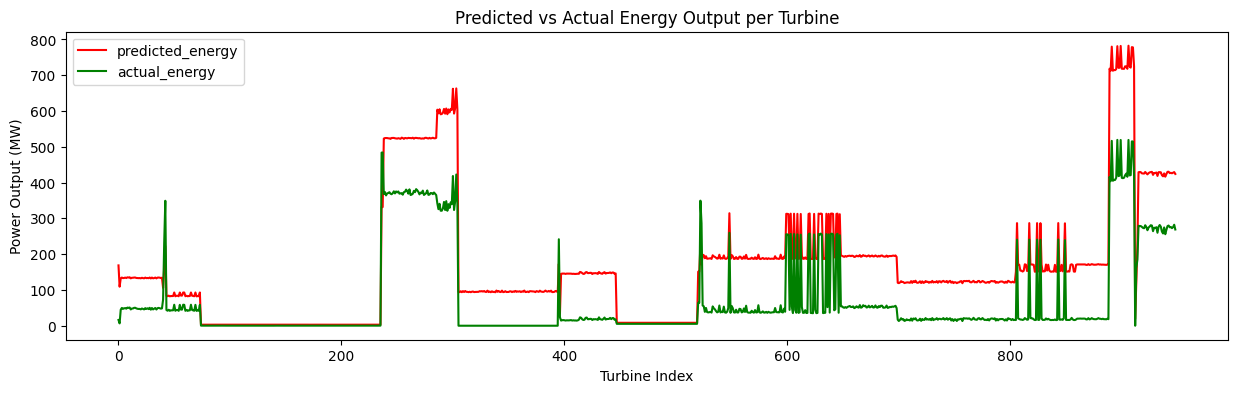

In [106]:
fig, ax = plt.subplots(figsize=(15, 4))
# cax = ax.imshow(sf_area_turbines_with_ws['predicted_energy - actual_energy'], cmap='viridis', aspect='auto')
sf_area_turbines_with_ws.reset_index().plot(kind='line', x='index', y='predicted_energy', ax=ax, color='red')
sf_area_turbines_with_ws.reset_index().plot(kind='line', x='index', y='actual_energy', ax=ax, color='green')
# sf_area_turbines_with_ws.reset_index().plot(kind='line', x='index', y='predicted_energy - actual_energy', ax=ax, color='black')
# sf_area_turbines_with_ws.reset_index(inplace=True).plot(kind='scatter', x=sf_area_turbines_with_ws.index, y='predicted_energy', color='red')


# df_topex.reset_index(inplace=True).plot(kind='scatter', x='Time', y='Anomaly', color='red'
plt.xlabel('Turbine Index')
plt.ylabel('Power Output (kW)') ## changed after printing the plot, should be kW instead of MW
# cbar = fig.colorbar(cax)
# cbar.set_label('Wind Speed')
plt.title('Predicted vs Actual Energy Output per Turbine')
plt.show()

# plt.xticks(ticks=np.arange(len(own_model_longitude_range)), labels=own_model_longitude_range)
# plt.yticks(ticks=np.arange(len(own_model_latitude_range)),labels=reversed(own_model_latitude_range))
# plt.title('Pyrecast Predictions for Wind Speed (2023-12-29 13:00)')

In [115]:
sf_area_turbines_with_ws.to_csv('/content/drive/My Drive/CS 663 - Project/sf_area_turbines_with_ws_5-10-3_pm.csv')

In [116]:
sf_area_turbines_with_ws['predicted_energy - actual_energy'].min()

-152.42450397021065

In [117]:
import geemap

import ee
ee.Authenticate()
ee.Initialize(project='project1-1531690201568')

import geopandas as gpd
import numpy as np

sf_area_turbines_gdf = gpd.read_file('/content/drive/My Drive/CS 663 - Project/sf_area_turbines_with_ws_5-10-3_pm.csv', ignore_geometry=True)
# Create geometry objects from WKT strings
sf_area_turbines_gdf['geometry'] = gpd.GeoSeries.from_wkt(sf_area_turbines_gdf['geometry'])

# Convert to GDF
sf_area_turbines_gdf = gpd.GeoDataFrame(sf_area_turbines_gdf)
sf_area_turbines_gdf

,field_1,t_manu,t_model,t_cap,t_hh,xlong,ylat,geometry,predicted_ws,actual_ws,predicted_ws - actual_ws,predicted_energy,actual_energy,predicted_energy - actual_energy
0,0,GE Wind,GE1.85-82.5,1850.0,80.0,-122.092079,38.233505,POINT (-122.09208 38.23351),4.771541638593837,3.157853234710956,1.6136884038828816,168.5589126803249,16.10260702150117,152.45630565882374
1,1,GE Wind,GE1.5-77,1500.0,65.0,-122.089287,38.232296,POINT (-122.08929 38.23230),4.77147701908512,3.1617198861277522,1.6097571329573679,109.06179383217153,6.468795445110089,102.59299838706144
2,2,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.644188,37.796196,POINT (-121.64419 37.79620),5.372907743544034,5.005712267470211,0.36719547607382275,132.00622747639204,44.63977395666366,87.36645351972838
3,3,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.666084,37.801395,POINT (-121.66608 37.80139),5.38383055842508,5.050606033484399,0.33322452494068067,134.5840117883189,49.66787575025273,84.91613603806616
4,4,Mitsubishi,MWT62/1.0,1000.0,55.0,-121.653885,37.802994,POINT (-121.65389 37.80299),5.3772593781423454,5.027925118573741,0.34933425956860464,133.03321324159353,47.12761328025897,85.90559996133456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,944,Siemens,SWT-2.3-101,2300.0,80.0,-121.709885,37.794193,POINT (-121.70988 37.79419),5.405048374808388,5.12237606382174,0.2826723109866478,427.2212849156906,275.92273404078276,151.29855087490785
945,945,Siemens,SWT-2.3-101,2300.0,80.0,-121.701584,37.789993,POINT (-121.70158 37.78999),5.401993255630378,5.107288310262412,0.29470494536796643,425.8770324773664,272.60342825773057,153.27360421963584
946,946,Siemens,SWT-2.3-101,2300.0,80.0,-121.710487,37.788895,POINT (-121.71049 37.78889),5.4058553179314055,5.120672318561625,0.28518299936978053,427.5763398898184,275.5479100835575,152.02842980626093
947,947,Siemens,SWT-2.3-101,2300.0,80.0,-121.726784,37.804794,POINT (-121.72678 37.80479),5.409711421848209,5.150679734608292,0.25903168723991765,429.27302561321216,282.14954161382417,147.123483999388


In [118]:
sf_area_turbines_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   field_1                           949 non-null    object  
 1   t_manu                            949 non-null    object  
 2   t_model                           949 non-null    object  
 3   t_cap                             949 non-null    object  
 4   t_hh                              949 non-null    object  
 5   xlong                             949 non-null    object  
 6   ylat                              949 non-null    object  
 7   geometry                          949 non-null    geometry
 8   predicted_ws                      949 non-null    object  
 9   actual_ws                         949 non-null    object  
 10  predicted_ws - actual_ws          949 non-null    object  
 11  predicted_energy                  949 non-null    

TO DO: change to energy visualization

Visualization done following example here: https://developers.google.com/earth-engine/apidocs/ee-featurecollection-style#colab-python

In [121]:
# print('max diff:', sf_area_turbines_gdf['predicted_ws - actual_ws'].max())
# print('min diff:' , sf_area_turbines_gdf['predicted_ws - actual_ws'].min())
max_energy_diff = pd.to_numeric(sf_area_turbines_gdf['predicted_energy - actual_energy']).max()
min_energy_diff = pd.to_numeric(sf_area_turbines_gdf['predicted_energy - actual_energy']).min()
print('max diff:', max_energy_diff)
print('min diff:' , min_energy_diff)

feature_list = []
igbp_palette = [
    'zone1',
    'zone2',
    'zone3',
    'zone4',
    'zone5',
    'zone6',
    'zone7',
    'zone8',
    'zone9'
]
r = max_energy_diff - min_energy_diff
spacing = r / 10
palette_arr = np.arange(min_energy_diff, max_energy_diff, spacing)
print(len(palette_arr))
palette_list = []


for index, row in sf_area_turbines_gdf.iterrows():

  ws_diff = row['predicted_ws - actual_ws']
  energy_diff = row['predicted_energy - actual_energy']
  # find correct idx
  correct_idx = 0
  for i in range(1, len(palette_arr) - 1):
    if float(energy_diff) >= palette_arr[i - 1] and float(energy_diff) <= palette_arr[i]:
      correct_idx = i
      break
  palette_list.append(correct_idx)
  feature = (
    ee.Feature(ee.Geometry.Point([float(sf_area_turbines_gdf.iloc[index, 5]), float(sf_area_turbines_gdf.iloc[index, 6])])).set('color', igbp_palette[correct_idx])
  )
  feature_list.append(feature)

fromList = ee.FeatureCollection(feature_list)

# FeatureCollection of power plants in Belgium.
fc = ee.FeatureCollection(feature_list)

# Paint FeatureCollection to an image using collection-wide style arguments.
# fc_vis = fc.style(
#     color='1e90ff',
#     width=2,
#     fillColor='ff475788',  # with alpha set for partial transparency
#     lineType='dotted',
#     pointSize=10,
#     pointShape='circle',
# )

# Display the FeatureCollection visualization (ee.Image) on the map.
m = geemap.Map()
# m.add_layer(fc_vis, None, 'Collection-wide style')

# Paint FeatureCollection to an image using feature-specific style arguments.
# A dictionary of style properties per power plant fuel type.
fuel_styles = ee.Dictionary({
    'zone1': {'color': '#f0f921', 'pointSize': 5},
    'zone2': {'color': '#fdc527', 'pointSize': 5},
    'zone3': {'color': '#f89540', 'pointSize': 5},
    'zone4': {'color': '#e66c5c', 'pointSize': 5},
    'zone5': {'color': '#cc4778', 'pointSize': 5},
    'zone6': {'color': '#aa2395', 'pointSize': 5},
    'zone7': {'color': '#7e03a8', 'pointSize': 5},
    'zone8': {'color': '#4c02a1', 'pointSize': 5},
    'zone9': {'color': '#0d0887', 'pointSize': 5}
})

# Add feature-specific style properties to each feature based on fuel type.
fc = fc.map(
    lambda feature: feature.set('style', fuel_styles.get(feature.get('color')))
)

# Style the FeatureCollection according to each feature's "style" property.
fc_vis_custom = fc.style(
    styleProperty='style',
    neighborhood=8,  # maximum "pointSize" + "width" among features
)

# Display the FeatureCollection visualization (ee.Image) on the map.
m.add_layer(fc_vis_custom, None, 'Feature-specific style')
m.centerObject(fc, 10)  # Center the map on the feature collection
m

max diff: 308.47659526241426
min diff: -152.42450397021065
10


Map(center=[37.82601307036532, -121.65164835828774], controls=(WidgetControl(options=['position', 'transparent…

In [122]:
for i in range(len(igbp_palette)):
  print("# turbines in range", i, ":", palette_list.count(i))

# turbines in range 0 : 42
# turbines in range 1 : 5
# turbines in range 2 : 2
# turbines in range 3 : 1
# turbines in range 4 : 237
# turbines in range 5 : 62
# turbines in range 6 : 237
# turbines in range 7 : 363
# turbines in range 8 : 0


In [107]:
palette_arr

array([-115.46708426,  -94.08825757,  -72.70943087,  -51.33060417,
        -29.95177748,   -8.57295078,   12.80587591,   34.18470261,
         55.5635293 ,   76.942356  ])

In [109]:
float(sf_area_turbines_gdf['predicted_energy - actual_energy'].min())

-115.46708426144636